### Preparing the Input for 12-lead

In [4]:
import os
from sklearn.preprocessing import StandardScaler
#import wfdb as wf
import numpy as np
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import glob
from scipy import signal
import pandas as pd
from tensorflow.python.keras.layers import Dense, Convolution1D, Convolution2D,MaxPool1D, Flatten, Dropout
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.normalization import BatchNormalization
import tensorflow.python.keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from sklearn import preprocessing
import pandas as pd
import numpy as np
import os,glob
import math
import fnmatch
import re
import gc
import shutil
from joblib import Parallel, delayed
#import matplotlib.pyplot as plt
import scipy.signal as scipysi
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, GRU
import shutil
#import matplotlib as plt
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,CuDNNLSTM,GlobalMaxPooling1D, MaxPool2D,Flatten
from tensorflow.python.keras.layers import Conv1D, Conv2D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, GlobalAveragePooling2D,Concatenate
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import initializers
from tensorflow.keras import regularizers, constraints
import tensorflow.keras.backend as K


from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from scipy import signal
from scipy.fft import fftshift

/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Loading data and playing with it

In [5]:
#constants

TARGET_SAMPLING_RATE=250
DATA_SAMPLING_RATE=500
INPUT_BEAT_SIZE=300

#paths
root_path='/Users/aring/Desktop/ECG-identification/Arnold-data'

DataFilePath = root_path+'/NoiseReductionData/'
LeadInfoFilePath = root_path+'/DiagnosisFiles/MissingLeadInfo/'
RepDiagnosisFileName = root_path+'/DiagnosisFiles/RepatTranslationDiagAfterRemDupAndBDQ_CHS20200531_ToArinG.xlsx'
FullDiagnosisFileName = root_path+'/DiagnosisFiles/TranslationDiagAfterRemDupAndBDQ_CHS20200531_ToArinG.xlsx'

In [6]:
RepDiagnosisDF = pd.read_excel(RepDiagnosisFileName)
RepDiagnosisDF.head()

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation
0,MUSE_20180113_180130_23000,219,1011931.0,85,Male,29/12/2016 10:52:16,['Sinus_Tachycardia']
1,MUSE_20180113_180131_30000,219,1011931.0,86,Male,29/05/2017 10:10:54,['Sinus_Tachycardia']
2,MUSE_20180113_180139_35000,219,1011931.0,86,Male,03/06/2017 07:34:27,['Sinus_Tachycardia']
3,MUSE_20180113_180143_59000,219,1011931.0,86,Male,04/11/2017 11:46:50,['Sinus_Tachycardia']
4,MUSE_20180113_131105_22000,542,1011931.0,86,Female,26/01/2017 12:50:33,[ 'Ventricular_Escape_Beat']


In [ ]:
FullDiagnosisDF = pd.read_excel(FullDiagnosisFileName)
FullDiagnosisDF.head()

In [16]:
a=RepDiagnosisDF.groupby(['PatientID']).size().reset_index(name='count')
a=a.sort_values(by=['count'],ascending=False)
a[a['count']>4].shape


(223, 2)

In [304]:

NonRepDiagnosisDF = FullDiagnosisDF.loc[~FullDiagnosisDF['FileName'].isin(RepDiagnosisDF['FileName'])]
NonRepDiagnosisDF = NonRepDiagnosisDF.reset_index(drop=True)
NonRepDiagnosisDF['PatientID'] = NonRepDiagnosisDF['FileName']

AllDiagnosisDF = pd.concat([RepDiagnosisDF, NonRepDiagnosisDF])
AllDiagnosisDF = AllDiagnosisDF.reset_index(drop=True)
le = preprocessing.LabelEncoder()
AllDiagnosisDF['PatientID_new'] = AllDiagnosisDF['PatientID'].astype('str')
AllDiagnosisDF['PatientID_new'] = le.fit_transform(AllDiagnosisDF['PatientID_new'])

In [305]:
AllDiagnosisDF.head()

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation,PatientID_new
0,MUSE_20180113_180130_23000,219,1011931.0,85,Male,29/12/2016 10:52:16,['Sinus_Tachycardia'],1673
1,MUSE_20180113_180131_30000,219,1011931.0,86,Male,29/05/2017 10:10:54,['Sinus_Tachycardia'],1673
2,MUSE_20180113_180139_35000,219,1011931.0,86,Male,03/06/2017 07:34:27,['Sinus_Tachycardia'],1673
3,MUSE_20180113_180143_59000,219,1011931.0,86,Male,04/11/2017 11:46:50,['Sinus_Tachycardia'],1673
4,MUSE_20180113_131105_22000,542,1011931.0,86,Female,26/01/2017 12:50:33,[ 'Ventricular_Escape_Beat'],2269


In [308]:
AllDiagnosisDF[AllDiagnosisDF['PatientID']==4181664]

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation,PatientID_new
1917,MUSE_20180113_115320_38000,4181664,1011948.0,68,Male,16/11/2016 08:45:50,"['Aberrant_Ventricular_Conduction', 'Atrial_Fi...",2145
1918,MUSE_20180113_115322_56000,4181664,1011948.0,69,Male,03/05/2017 10:40:54,"['Atrial_Flutter', 'Intraventricular_Block']",2145
1919,MUSE_20180113_115323_64000,4181664,1011948.0,69,Male,03/05/2017 09:20:45,"['Atrial_Flutter', 'Intraventricular_Block']",2145
1920,MUSE_20180113_115325_79000,4181664,1011948.0,69,Male,07/06/2017 10:03:37,"['Atrial_Flutter', 'Intraventricular_Block']",2145
1921,MUSE_20180113_115326_85000,4181664,1011948.0,69,Male,17/05/2017 09:49:30,"['Atrial_Flutter', 'Intraventricular_Block']",2145
1922,MUSE_20180113_115319_29000,4181664,1011948.0,68,Male,16/11/2016 10:27:16,['Atrial_Flutter'],2145
1923,MUSE_20180113_115321_49000,4181664,1011948.0,69,Male,19/04/2017 09:29:51,['Atrial_Flutter'],2145
1924,MUSE_20180113_115324_71000,4181664,1011948.0,69,Male,28/06/2017 10:58:31,['Atrial_Flutter'],2145
1925,MUSE_20180113_115329_14000,4181664,1011948.0,68,Male,21/09/2016 08:56:45,['Atrial_Flutter'],2145
1926,MUSE_20180113_115330_21000,4181664,1011948.0,68,Male,28/09/2016 09:40:30,['Atrial_Flutter'],2145


In [111]:
FullDiagnosisDF = pd.read_excel(FullDiagnosisFileName)
FullDiagnosisDF

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation
0,MUSE_20180115_124154_98000,880947374,1012016.0,20,Female,25/09/2017 15:32:26,[ 'Sinus_Tachycardia']
1,MUSE_20180112_071158_01000,880957431,1012016.0,22,Female,16/11/2017 15:55:09,[ 'Sinus_Tachycardia']
2,MUSE_20180114_123835_64000,880878772,1011949.0,67,Female,26/10/2016 10:55:48,"[ 'Clockwise_Rotation', 'Complete_LBBB', 'Sinu..."
3,MUSE_20180210_124733_04000,2968425,1011949.0,68,Male,04/11/2017 19:30:02,"[ 'Clockwise_Rotation', 'Myocardial_Infarction..."
4,MUSE_20180118_173322_76000,10956457,1011952.0,65,Female,10/05/2017 10:35:22,"[ 'Clockwise_Rotation', 'Sinus_Tachycardia']"
...,...,...,...,...,...,...,...
45303,MUSE_20180116_121305_58000,880938543,1011981.0,36,Male,15/08/2017 16:32:00,['VT']
45304,MUSE_20180120_123539_01000,880968276,1011988.0,30,Female,16/01/2018 18:06:02,['VT']
45305,MUSE_20180120_122254_36000,10183314,1012010.0,6,Female,23/11/2016 20:19:05,['Wandering_Pacemakerwithin_Sinoatrial_Node']
45306,MUSE_20180116_124311_28000,11106793,1011938.0,78,Female,16/01/2016 11:41:35,['Wandering_Pacemakerwithin_Sinoatrial_Node']


In [136]:
FullDiagnosisDF.shape

(45308, 7)

In [138]:
age_gender_df=FullDiagnosisDF[['PatientID','Age','Gen']]
age_gender_df.head()

,PatientID,Age,Gen
0,880947374,20,Female
1,880957431,22,Female
2,880878772,67,Female
3,2968425,68,Male
4,10956457,65,Female


In [139]:
age_gender_df.to_csv('/Users/aring/Desktop/ECG-identification/age_gender.csv')

In [113]:
leadinfoDF = pd.read_excel(LeadInfoFilePath + 'MUSE_20180111_170356_27000' + '.xlsx')
leadinfoDF.head()

,Var1,Var2
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False


In [114]:
leadinfoDF.shape

(12, 2)

In [117]:
sample_record = pd.read_csv(DataFilePath + 'noise-reduc-all/NoiseReductionData/'+'MUSE_20180112_070939_20000' + '.csv', header=None)
sample_record.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-44.944,-16.279,8.5933,25.355,-26.101,-6.0976,-51.235,-57.090,-45.905,-54.620,-21.231,14.0490
1,-50.910,-22.374,8.6467,31.734,-28.214,-8.6359,-51.259,-60.730,-49.903,-57.047,-24.873,7.9470
2,-57.153,-29.420,8.0254,38.785,-30.269,-12.1520,-51.659,-64.809,-53.887,-59.625,-29.008,1.6642
3,-63.350,-37.508,6.3144,46.402,-31.999,-16.9680,-52.452,-69.387,-57.537,-62.235,-33.709,-4.5832
4,-68.634,-45.746,3.5399,53.644,-33.037,-22.5800,-53.271,-74.064,-60.240,-64.508,-38.522,-10.1500


In [118]:
sample_record.shape

(5000, 12)

In [119]:
channel = sample_record[0].values
ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
num_of_beats=ecg_info_extracted['templates'].shape[0]
beat_size=ecg_info_extracted['templates'].shape[1]
print(num_of_beats)
print(beat_size)


19
300


In [120]:
heart_beats_12lead = np.array(ecg_info_extracted['templates'], dtype=np.float)
heart_beats_12lead.shape

(19, 300)

In [121]:
channel = sample_record[1].values
ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
heart_beats_12lead=np.append(heart_beats_12lead,ecg_info_extracted['templates'],1)
heart_beats_12lead.shape


(19, 600)

In [122]:
if any(~leadinfoDF.iloc[:, 0]):
    print('missing some leaseds!')
else:
     print('has all leads!')

has all leads!


In [123]:
#this creates a matrix where  each row is a beat, 12 leads stored one after another in that row (each lead is 300 smaples)
for i in [1,0,2,3,4,5,6,7,8,9,10,11]:
    channel = sample_record[i].values
    try:
        ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
        if i==1:
            heart_beats_12lead = np.array(ecg_info_extracted['templates'], dtype=np.float)
            lead1_beats=ecg_info_extracted['templates']
        else:
            heart_beats_12lead = np.append(heart_beats_12lead,ecg_info_extracted['templates'],1)
    except Exception as e:
        if i==1:
            break
        print('error in processing the leads:'+ str(i))
        heart_beats_12lead = np.append(heart_beats_12lead,np.zeros_like(lead1_beats),1)
        continue


heart_beats_12lead.shape


(19, 3600)

In [124]:
ecg_info_extracted['templates'].shape

(19, 300)

In [125]:
heart_beats_12lead[:,2*300:3*300]

array([[-18.13456949, -17.62687377, -17.08459724, ..., -20.57877766,
        -23.10124215, -25.19957523],
       [-17.13388225, -16.28698359, -15.31613171, ..., -21.90872581,
        -23.85870663, -24.6684356 ],
       [-13.35416922, -13.0744338 , -12.77143781, ..., -17.46681087,
        -19.04744205, -21.00455269],
       ...,
       [-14.77531711, -14.28855901, -13.87134876, ..., -18.76016624,
        -18.4452355 , -19.0769272 ],
       [-13.35531235, -12.73198025, -12.17661534, ...,  -7.53141091,
         -8.95909886, -10.90518262],
       [-14.32165088, -13.3106402 , -12.43055031, ..., -11.62177154,
        -12.16643547, -13.23792191]])

In [133]:
beat1_12lead = np.reshape(heart_beats_12lead[0], (12, 300))
beat1_12lead.shape

(12, 300)

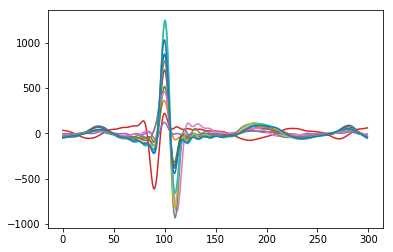

In [135]:
#draw all 12 leads for the first beat
for i in range(0,11):
    plt.plot( beat1_12lead[i,:]) 

plt.show()

In [128]:
#add the lalber to each row for each beat
beat1_12lead
num_patientID=123
label_column = np.repeat(num_patientID, beat1_12lead.shape[0])
label_column=np.reshape(label_column, (label_column.shape[0], 1))
beat1_12lead_with_label=np.append(beat1_12lead,label_column,1)
print(beat1_12lead_with_label.shape)
# print(beat1_12lead_with_label[0,])

(12, 301)


### Preprocssing 12-lead data and Storing the input to NN

In [27]:


def generate_12lead_input_for_NN(num_patientID, diagnosis, signalFile):
    NoiseReductionData_dirs=['NoiseReductionData1','NoiseReductionData2','NoiseReductionData3','NoiseReductionData4','NoiseReductionData5','NoiseReductionData6']
    path_does_not_Exist=True
    for dir_name in NoiseReductionData_dirs:
        path = DataFilePath + dir_name+'/'+ signalFile + '.csv'
        if os.path.exists(path):
            path_does_not_Exist=False
            break;
    if path_does_not_Exist:
        print('File does not exist:', signalFile)
        return np.repeat(None, 1)
    
    all_beats_12lead_with_label_diagnosis = np.empty((0,12,INPUT_BEAT_SIZE+2), dtype=np.float)
    record = pd.read_csv(path, header=None)
    leadinfoDF = pd.read_excel(LeadInfoFilePath + signalFile + '.xlsx')
    
    for i in [1,0,2,3,4,5,6,7,8,9,10,11]:
        channel = record[i].values
        try:
            ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
            if i==1:
                heart_beats_12lead = np.array(ecg_info_extracted['templates'], dtype=np.float)
                lead1_beats=ecg_info_extracted['templates']
                num_of_beats=lead1_beats.shape[0]
            else:
                heart_beats_12lead = np.append(heart_beats_12lead,ecg_info_extracted['templates'],1)
        except Exception as e:
            if i==1:
                return np.repeat(None, 1)
            else:
                heart_beats_12lead = np.append(heart_beats_12lead,np.zeros_like(lead1_beats),1)
                
    for i in range(0,num_of_beats):
        one_beat_12lead = np.reshape(heart_beats_12lead[i], (12, 300))
        label_column = np.repeat(num_patientID, one_beat_12lead.shape[0])
        label_column=np.reshape(label_column, (label_column.shape[0], 1))
        diagnosis_column=np.repeat(diagnosis, one_beat_12lead.shape[0])
        diagnosis_column=np.reshape(diagnosis_column, (diagnosis_column.shape[0], 1))
        one_beat_12lead_with_label = np.append(one_beat_12lead,label_column,1)
        one_beat_12lead_with_label_diagnosis = np.append(one_beat_12lead_with_label,diagnosis_column,1)
        one_beat_12lead_with_label_diagnosis = np.reshape(one_beat_12lead_with_label_diagnosis,(1,12,302))
        all_beats_12lead_with_label_diagnosis=np.vstack((all_beats_12lead_with_label_diagnosis,one_beat_12lead_with_label_diagnosis))
    

    return all_beats_12lead_with_label_diagnosis

   

In [28]:
x=generate_12lead_input_for_NN(123,['Sinus_Tachycardia'],'MUSE_20180111_170356_27000')

In [29]:
x[0]

array([['-40.719956926829624', '-40.844754001609466',
        '-40.63335164906105', ..., '54.31228077099648', '123.0',
        'Sinus_Tachycardia'],
       ['-14.299994121880898', '-12.951280481990485',
        '-11.416985294399705', ..., '14.764532947005735', '123.0',
        'Sinus_Tachycardia'],
       ['0.0', '0.0', '0.0', ..., '0.0', '123.0', 'Sinus_Tachycardia'],
       ...,
       ['-15.00218762655504', '-13.176144880710474',
        '-11.256069088311921', ..., '34.55045611154739', '123.0',
        'Sinus_Tachycardia'],
       ['-3.9269471638104085', '-4.477020922562214',
        '-4.846829608520115', ..., '22.714660699953154', '123.0',
        'Sinus_Tachycardia'],
       ['-16.29128183523312', '-14.2946982583345', '-12.115651880793529',
        ..., '29.797783843492336', '123.0', 'Sinus_Tachycardia']],
      dtype='<U32')

In [30]:
NonRepDiagnosisDF = FullDiagnosisDF.loc[~FullDiagnosisDF['FileName'].isin(RepDiagnosisDF['FileName'])]
NonRepDiagnosisDF = NonRepDiagnosisDF.reset_index(drop=True)
NonRepDiagnosisDF['PatientID'] = NonRepDiagnosisDF['FileName']

AllDiagnosisDF = pd.concat([RepDiagnosisDF, NonRepDiagnosisDF])
AllDiagnosisDF = AllDiagnosisDF.reset_index(drop=True)
le = preprocessing.LabelEncoder()
AllDiagnosisDF['PatientID'] = AllDiagnosisDF['PatientID'].astype('str')
AllDiagnosisDF['PatientID'] = le.fit_transform(AllDiagnosisDF['PatientID'])


In [ ]:

num_cores =6
   

results = Parallel(n_jobs=num_cores)(delayed(generate_12lead_input_for_NN)
            (AllDiagnosisDF['PatientID'][indexFile],AllDiagnosisDF['Translation'][indexFile],signalFile) for indexFile, signalFile in enumerate(AllDiagnosisDF['FileName']))


/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:

# Save to CSV file.
outfn = root_path+'/FeatureArray_stacked_pcs.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, FeatureArray3, delimiter=",", fmt='%f')


In [ ]:
len(results)

In [ ]:
def split_train_test(patient_rows):
    random_rows=np.random.choice(patient_rows.shape[0], size=2, replace=False)
    test=patient_rows[random_rows,:,:]
    train=np.delete(patient_rows,random_rows,0)
    return train,test

train,test = map(list,zip(*[split_train_test(i) for i in results if  i.any()]))

In [ ]:
print(len(train))
print(len(test))
num_of_people_in_data=len(train)


In [ ]:
train_stacked = np.row_stack(train)
test_stacked = np.row_stack(test)

print('train beats: '+str(train_stacked.shape))
print('test beats: '+str(test_stacked.shape))
print('total number of beats: '+str(train_stacked.shape[0]+test_stacked.shape[0]))

In [ ]:
train_X=train_stacked[:,:,:-2]
train_y=train_stacked[:,:,-2]
train_diagnosis=train_stacked[:,:,-1]

test_X=test_stacked[:,:,:-2]
test_y=test_stacked[:,:,-2]
test_diagnosis=train_stacked[:,:,-1]
2

print('train_X: '+str(train_X.shape))
print('train_y: '+str(train_y.shape))
print('train_diagnosis: '+str(train_diagnosis.shape))


print('test_X: '+str(test_X.shape))
print('test_X: '+str(test_y.shape))
print('test_diagnosis: '+str(test_diagnosis.shape))



In [ ]:

# reshaping to 2D array so that npsavetxt can save it
outfn = root_path+'/nn-input/train_X.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, train_X.reshape((train_X.shape[0],12*300)), delimiter=",", fmt='%f')


# Save to CSV file.
outfn = root_path+'/nn-input/train_y.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, train_y, delimiter=",", fmt='%f')


# Save to CSV file.
outfn = root_path+'/nn-input/test_X.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, test_X.reshape((test_X.shape[0],12*300)), delimiter=",", fmt='%f')

    

# Save to CSV file.
outfn = root_path+'/nn-input/test_y.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, test_y, delimiter=",", fmt='%f')
    


# Save to CSV file.
outfn = root_path+'/nn-input/test_diagnosis.csv'
with open(outfn, "wb") as fin
    np.savetxt(fin, test_diagnosis, delimiter=",", fmt='%f')
    
    


# Save to CSV file.
outfn = root_path+'/nn-input/train_diagnosis.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, train_diagnosis, delimiter=",", fmt='%f')


### PCA


In [ ]:
res_no_nulls = [i[:,:,:-2] for i in results if  i.any()] 

In [ ]:
len(res_no_nulls)

In [ ]:
res_no_nulls[1].shape

In [ ]:
FeatureArray = np.row_stack(res_no_nulls)
FeatureArray.shape

In [ ]:
FeatureArray2 = np.column_stack(FeatureArray)
FeatureArray2.shape

In [ ]:
FeatureArray3=FeatureArray2.transpose()
FeatureArray3.shape

In [ ]:
#draw all 12 leads for the first beat
for i in range(0,11):
    plt.plot( FeatureArray3[:300,i]) 

plt.show()

In [ ]:

# a flexible function that plots 3d maps
def plot3D(ds=None, labels=None, comp=None, fig=None, axloc=111, xlim=[-4,4], 
           ylim=[-4,4], zlim=[-4,4], xc=5, yc=5, zc=5):    
    if fig is None:
        fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(axloc, projection='3d')
    colors = ('red', 'blue', 'green', 'yellow', 'cyan', 'black', 'purple', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(labels))])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    if ds is not None:
        if labels is not None:
            ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], marker='.', 
                       alpha=1, lw=0, c=cmap(labels))
        else:
            ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], marker='.', 
                       alpha=1, lw=0)
    
    if comp is not None:
        # add principal components here:
        for i in np.arange(len(comp)):
            ax.plot([-xc*comp[i, 0], xc*comp[i, 0]],
                    [-yc*comp[i, 1], yc*comp[i, 1]],
                    zs=[-zc*comp[i, 2], zc*comp[i, 2]])

    return fig, ax

In [ ]:
X=FeatureArray3
sc = StandardScaler() 
X_std = sc.fit_transform(X) 

In [ ]:
X_std.shape

In [ ]:
pca = PCA()
x_pca = pca.fit_transform(X_std)

In [ ]:
print(pca.components_.shape)
print(x_pca.shape)

In [ ]:
f, ax = plot3D(ds=x, comp=pca.components_, axloc=221)
ax.set_title('PCA Components')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')




ax = f.add_subplot(222)
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
ax.plot(pca.explained_variance_ratio_, 'o-')
ax.set_title("Variance explained")
ax.set_ylabel("variances")
ax.set_xlabel("Components kept")
ax.legend(['Cumulative variances explained', 'Explained variances'])

plt.figure(figsize=(12, 9))

plt.tight_layout()

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
#projected 12 leads
for i in range(0,11):
    plt.plot( x_pca[:300,i]) 

plt.show()

### Spectogram(converting 1D ECG signal to a 2D image)

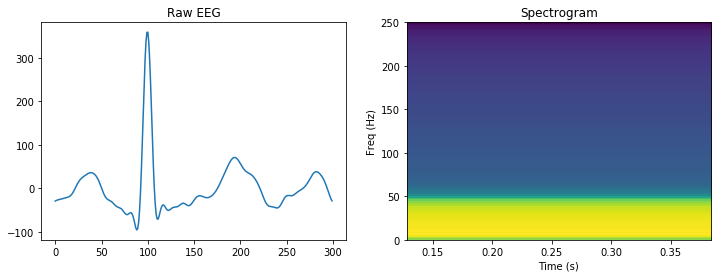

In [105]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.plot(beat1_12lead[1,:]); ax1.set_title('Raw EEG')
ax2.specgram(beat1_12lead[1,:], Fs=DATA_SAMPLING_RATE); ax2.set_title('Spectrogram'); ax2.set_ylabel('Freq (Hz)');
ax2.set_xlabel('Time (s)');

In [ ]:
f1, PSD = signal.periodogram(beat1_12lead[1,:], DATA_SAMPLING_RATE, 'flattop', scaling = 'density')
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel = 'Frequency [Hz]', xlim = [0, INPUT_BEAT_SIZE-1], xticks = np.arange(0, INPUT_BEAT_SIZE-1+5, 10))
ax1.set(ylabel = 'PSD')
plt.title('Power spectral density (PSD)', fontsize = 15)
fig.savefig('physionet_ECG_PSD.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [ ]:
def spectrogram(data, nperseg=64, noverlap=32, log_spectrogram = True):
    fs = 300
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    Sxx = np.transpose(Sxx,[0,2,1])
    if log_spectrogram:
        Sxx = abs(Sxx) # Make sure, all values are positive before taking log
        mask = Sxx > 0 # We dont want to take the log of zero
        Sxx[mask] = np.log(Sxx[mask])
    return f, t, Sxx


In [ ]:

ts_extended=beat1_12lead[1,:]

# Convert ECG into spectrograms without and with log transform
Sx = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False)[2]
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = True)[2]

# Get the frequency and time axes
f, t, _ = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False) 

# Plot the spectrograms as images
im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize = (15, 3))

for i, ax in enumerate(ax_list):
    
    ax.imshow(np.transpose(im_list[i]), aspect = 'auto', cmap = 'jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize = 12)
    ax.set(ylim = [0, im_list[i].shape[1]], yticks = np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]')
    
    # Replace axis labels with time from t array
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim = [0, im_list[i].shape[0]], xticks = xticks_array)
    labels_new = [str(np.around(t[label], decimals = 1)) for label in xticks_array]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis = 'x',
                   which = 'both',
                   bottom = 'off')
    
    ax.tick_params(axis = 'y',
                   which = 'both',
                   left = 'off')

plt.tight_layout()
plt.show()
fig.savefig('physionet_ECG_spectrogram.png', bbox_inches = 'tight', dpi = 150)

### CNN Model on 12-lead ECG Data

In [ ]:
train_X_loaded=np.loadtxt(root_path+'/nn-input/train_X.csv', delimiter=',')

In [ ]:
train_X_loaded.shape

In [ ]:
train_X_loaded=train_X_loaded.reshape(train_X_loaded.shape[0],12,300)

In [ ]:
train_X_loaded.shape

In [ ]:
for i in range(0,11):
    plt.plot( train_X_loaded[1000,i,:]) 

plt.show()

In [ ]:
train_Y_loaded=np.loadtxt(root_path+'/nn-input/train_Y.csv', delimiter=',')
train_Y_loaded.shape

In [ ]:
train_Y_loaded=train_Y_loaded[:,0]
train_Y_loaded.shape

In [ ]:
# le = preprocessing.LabelEncoder()
# train_Y_loaded_encoded = le.fit_transform(train_Y_loaded)

In [ ]:
train_Y_loaded_encoded.shape

In [ ]:
test_X_loaded=np.loadtxt(root_path+'/nn-input/test_X.csv', delimiter=',')
test_X_loaded=test_X_loaded.reshape(test_X_loaded.shape[0],12,300)

In [ ]:
test_Y_loaded=np.loadtxt(root_path+'/nn-input/test_Y.csv', delimiter=',')
test_Y_loaded=test_Y_loaded[:,0]
# le = preprocessing.LabelEncoder()
# test_Y_loaded_encoded = le.fit_transform(test_Y_loaded)


### VGG16 Model

In [ ]:
test_Y_loaded.shape

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()


In [ ]:
from keras.models import Sequential
type(vgg16_model) #This is a Keras Functional API need to convert to sequential
# model = Sequential() #Iterate over the functional layers and add it as a stack
model = tensorflow.keras.Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [ ]:
model.layers.pop()
model.summary()

In [ ]:
for layer in model.layers: #Since the model is already trained with certain weights, we dont want to change it. Let it be the same
    layer.trainable = False

In [ ]:
model.add(Dense(num_of_people_in_data, activation='softmax', name='main_output_final'))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(train_X_loaded, train_Y_loaded_encoded,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(test_X_loaded,test_Y_loaded_encoded))
model.load_weights('best_model.h5')

### CNN model

In [178]:
def network(X_train,y_train,X_test,y_test):
    im_shape=(12,300,1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution2D(32, (5,5), activation='relu', padding="same", input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool2D(pool_size=(2,2))(conv1_1)
    conv2_1=Convolution2D(64, (5,5), padding="same", activation='relu')(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool2D(pool_size=(2,2))(conv2_1)
    conv3_1=Convolution2D(128, (5,5), padding="same", activation='relu')(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool2D(pool_size=(2,2))(conv3_1)
#     conv4_1=Convolution2D(256, (5,5), padding="same", activation='relu')(pool3)
#     conv4_1=BatchNormalization()(conv4_1)
#     pool4=MaxPool2D(pool_size=(2,2))(conv4_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(128, activation='relu')(flatten)
    dense_end2 = Dense(50, activation='relu')(dense_end1)
    main_output = Dense(num_of_people_in_data, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['sparse_categorical_accuracy'])
    
        

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
test_Y_loaded.shape

In [ ]:
x_train_reshaped = train_X_loaded.reshape((-1, 12, 300, 1))
test_X_reshaped=test_X_loaded.reshape((-1, 12, 300, 1))
test_Y_loaded_encoded=to_categorical(test_Y_loaded)
train_Y_loaded_encoded=to_categorical(train_Y_loaded)


In [172]:
le = preprocessing.LabelEncoder()
le.fit(train_Y_loaded)
train_Y_loaded_encoded = le.transform(train_Y_loaded)
test_Y_loaded_encoded = le.transform(test_Y_loaded)

In [174]:
train_Y_loaded_encoded.shape

(121179,)

In [ ]:
model,history=network(x_train_reshaped,train_Y_loaded_encoded,test_X_reshaped,test_Y_loaded_encoded)

Train on 121179 samples, validate on 22056 samples
Epoch 1/40
121152/121179 [============================>.] - ETA: 6s - loss: 5.7905 - sparse_categorical_accuracy: 0.1518 

### Conv1D

In [ ]:
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],X_train.shape[2])
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation=tf.nn.relu, input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation=tf.nn.relu, input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation=tf.nn.relu, input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    conv4_1 = Convolution1D(128, (5), activation=tf.nn.relu, input_shape=im_shape)(pool3)
    conv4_1 = BatchNormalization()(conv4_1)
    pool4 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)

    conv5_1 = Convolution1D(128, (7), activation=tf.nn.relu, input_shape=im_shape)(pool4)
    conv5_1 = BatchNormalization()(conv5_1)
    pool5 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv5_1)

    flatten=Flatten()(pool5)
    dense_end1 = Dense(128, activation=tf.nn.relu)(flatten)
    dense_end2 = Dense(64, activation=tf.nn.relu)(dense_end1)
    main_output = Dense(num_of_people_in_data, activation=tf.nn.softmax, name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.summary()
    #model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'])
    
    #callbacks = [EarlyStopping(monitor='val_loss', patience=8),
     #        ModelCheckpoint(filepath='G:\\BioSigIdentification\\ECGData\\SXNBData\\best_model.h5', monitor='val_loss', save_best_only=True)]

    #history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    history = model.fit(X_train, y_train, epochs=80, batch_size=64,
                        validation_data=(X_test, y_test))
    #model.load_weights('G:\\BioSigIdentification\\ECGData\\SXNBData\\best_model.h5')
    return(model,history)



In [ ]:

Reshape_size = [X_test.shape[1],1]
model = network(Reshape_size, num_of_people_in_data)
model.summary()

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(128)
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(buffer_size=y_train.shape[0], reshuffle_each_iteration=True)

imodel=0
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(y_train.shape[0] / (batch_size)), validation_data=val_dataset)#, callbacks=callbacks)

model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))

model,history=network(X_train,y_train,X_test,y_test)
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

#predicted class vs actual, some examples
print(list(y_pred.argmax(axis=1)[1:20]))
print(list(target_test[1:20]))


In [ ]:

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(12, 300)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
FeatureArray=np.loadtxt('G:/BioSigIdentification/ECGData/SXNBData/FeatureArray.csv', delimiter=',')
le = preprocessing.LabelEncoder()
Counter(FeatureArray[:,300])
CountDF = pd.Series(Counter(FeatureArray[:,300]))
CountDF = CountDF.sort_values()
Over100Index = CountDF.loc[CountDF>5].index
FeatureArray = FeatureArray[np.isin(FeatureArray[:,300], Over100Index),:]

FeatureArray[:,300] = le.fit_transform(FeatureArray[:,300])

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)


In [ ]:

def network2(X_train,y_train,X_test,y_test):
    im_shape=(12,300,1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution2D(32, (5,5), activation='relu', padding="same", input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool2D(pool_size=(2,2))(conv1_1)
    conv2_1=Convolution2D(64, (5,5), padding="same", activation='relu')(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool2D(pool_size=(2,2))(conv2_1)
    conv3_1=Convolution2D(128, (5,5), padding="same", activation='relu')(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool2D(pool_size=(2,2))(conv3_1)
    conv4_1=Convolution2D(256, (5,5), padding="same", activation='relu',data_format='channels_first')(pool3)
    conv4_1=BatchNormalization()(conv4_1)
    pool4=MaxPool2D(pool_size=(2,2))(conv4_1)
    conv5_1=Convolution2D(512, (5,5), padding="same", activation='relu',data_format='channels_first')(pool4)
    conv5_1=BatchNormalization()(conv5_1)
    pool5=MaxPool2D(pool_size=(2,2))(conv5_1)
    flatten=Flatten()(pool5)
    dense_end1 = Dense(512, activation='relu')(flatten)
    dense_end2 = Dense(200, activation='relu')(dense_end1)
    main_output = Dense(num_of_people_in_data, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['sparse_categorical_accuracy'])
    
        

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

### Residual Network


### LSTM


### convolutional neural network plus LSTM layers and an attention module


### detecting the disease first and then narrowing the search to that group
this will be a multi-level bayesian risk calculation. first the accuracy of diease detection for each disease and then the accuracy of the detection in that group. then we generalize these results to all human population. how sure we are about the identification result, how much noise should we add to bring the accuracy say to 80% or 70%

 #### differential privacy 
 rarity of disease(we can get from other sources how many people in world have that condition) and then the noise needed to make it epsilon differentially private (how to caculate this for ecg input to neural network while keeping the information in the ECG data). for publishing an aggregated result. what diseases are harder to do a privacy-preserving analysis.

In [6]:
output_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all'


In [7]:
# trainX = np.loadtxt(output_path+'/trainX.csv', delimiter=',')
# testX = np.loadtxt(output_path+'/testX.csv', delimiter=',')

# trainY = np.loadtxt(output_path+'/trainY.csv', delimiter=',')
# testY = np.loadtxt(output_path+'/testY.csv', delimiter=',')

train_diagnosis = pd.read_csv(output_path+'/train-diagnosis.csv', delimiter=':')
test_diagnosis =  pd.read_csv(output_path+'/test-diagnosis.csv', delimiter=':')



In [8]:
testX.shape


NameError: name 'testX' is not defined

In [14]:
test_diagnosis.shape

(479595, 2)

In [ ]:
test_daignosis=pd.read_csv(output_path+'/test-diagnosis.csv', delimiter=':',names=['id','diagnosis'])
test_daignosis.info()

In [34]:
test_daignosis['diagnosis']=test_daignosis['diagnosis'].apply(lambda x: x.strip('][').split(', ') )

In [35]:
test_daignosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         18 non-null     float64
 1   diagnosis  18 non-null     object 
dtypes: float64(1), object(1)
memory usage: 416.0+ bytes


In [36]:
len(test_daignosis['diagnosis'][0])

1

In [37]:
def unnest(df, col, reset_index=False):
    import pandas as pd
    col_flat = pd.DataFrame([[i, x] 
                       for i, y in df[col].apply(list).iteritems() 
                           for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')
    df = df.drop(col, 1)
    df = df.merge(col_flat, left_index=True, right_index=True)
    if reset_index:
        df = df.reset_index(drop=True)
    return df

In [39]:
flattened_diagnosis = unnest(test_daignosis, 'diagnosis')

In [40]:
flattened_diagnosis


,id,diagnosis
0,1673.0,'Sinus_Tachycardia'
1,1673.0,'Sinus_Tachycardia'
2,1673.0,'Sinus_Tachycardia'
3,1673.0,'Sinus_Tachycardia'
4,1673.0,'Sinus_Tachycardia'
5,1673.0,'Sinus_Tachycardia'
6,1673.0,'Sinus_Tachycardia'
7,1673.0,'Sinus_Tachycardia'
8,2269.0,'Ventricular_Escape_Beat'
9,2269.0,'Ventricular_Escape_Beat'


In [47]:
print(test_daignosis.iloc[16]


id                                                        1052
diagnosis    ['1AVBlock', 'Atrial_Premature_Beat', 'Atrial_...
Name: 16, dtype: object


In [167]:
# file_path='/Users/aring/Desktop/ECG-identification/missidentification-per-disease.csv'
file_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all/missidentification-per-joint-disease.csv'

by_disease = (pd.read_csv(file_path)).set_index('diagnosis').sort_values(by=['count'],ascending=False)
by_disease.head(n=10)


,count
diagnosis,
['Sinus_Bradycardia'],576
['Atrial_Fibrillation'],363
['Sinus_Rhythm'],257
['Sinus_Tachycardia'],195
['Atrial_Flutter'],75
['Sinus_Irregularity'],71
"['Atrial_Fibrillation','Pacemaker_ECG','Pacemaker_ECG']",68
"['Atrial_Fibrillation','Pacemaker_ECG']",55
['Ventricular_Fibrillation'],53


In [168]:
# by_disease.to_csv('/Users/aring/Desktop/ECG-identification/missidentification-per-disease-sorted.csv')

In [169]:
# file_path='/Users/aring/Desktop/ECG-identification/success-identification-per-disease.csv'
file_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all/success-identification-per-joint-disease.csv'

coorrect_classifications = (pd.read_csv(file_path)).set_index('diagnosis').sort_values(by=['count'],ascending=False)
coorrect_classifications.head(n=10)

,count
diagnosis,
['Sinus_Bradycardia'],24908
['Sinus_Rhythm'],13843
['Sinus_Tachycardia'],10389
['Atrial_Fibrillation'],8821
['Sinus_Irregularity'],3405
['Atrial_Flutter'],1957
"['1AVBlock','Sinus_Bradycardia']",978
"['Sinus_Bradycardia','Sinus_Irregularity']",852
['SVT'],851


In [170]:
all_classifications=coorrect_classifications.merge(by_disease, left_on='diagnosis', right_on='diagnosis')
all_classifications.head(n=10)

,count_x,count_y
diagnosis,,
['Sinus_Bradycardia'],24908,576
['Sinus_Rhythm'],13843,257
['Sinus_Tachycardia'],10389,195
['Atrial_Fibrillation'],8821,363
['Sinus_Irregularity'],3405,71
['Atrial_Flutter'],1957,75
"['1AVBlock','Sinus_Bradycardia']",978,30
"['Sinus_Bradycardia','Sinus_Irregularity']",852,20
['SVT'],851,19


In [171]:
all_classifications['sum_classifications']=all_classifications['count_x']+all_classifications['count_y']

In [172]:
all_classifications.head(n=10)

,count_x,count_y,sum_classifications
diagnosis,,,
['Sinus_Bradycardia'],24908,576,25484
['Sinus_Rhythm'],13843,257,14100
['Sinus_Tachycardia'],10389,195,10584
['Atrial_Fibrillation'],8821,363,9184
['Sinus_Irregularity'],3405,71,3476
['Atrial_Flutter'],1957,75,2032
"['1AVBlock','Sinus_Bradycardia']",978,30,1008
"['Sinus_Bradycardia','Sinus_Irregularity']",852,20,872
['SVT'],851,19,870


In [173]:
all_classifications['missclassificsation_ratio']=all_classifications['count_y']/all_classifications['sum_classifications']


In [174]:
all_classifications=all_classifications.sort_values(by=['missclassificsation_ratio'],ascending=False)
all_classifications.rename(columns = {'count_x':'correct_classification','count_y':'missclassification'}, inplace = True)
# all_classifications.head(n=20)
all_classifications_1=all_classifications[all_classifications['sum_classifications']>100]
all_classifications_2=all_classifications_1.drop(['correct_classification','missclassification'], axis=1)
all_classifications_2.rename(columns = {'sum_classifications':'number of heart beats','missclassificsation_ratio':'missclassificsation ratio'}, inplace = True)
all_classifications_2.style.set_table_styles([{'selector': 'caption','props': [('text-align','center'),('color', 'red'),('font-size', '16px')]}]).set_caption('Missclassifications ratio (the number of heart beats classified correctly vs incorrectly)')



,number of heart beats,missclassificsation ratio
diagnosis,,
['Ventricular_Fibrillation'],114,0.464912
['Ventricular_Escape_Beat'],114,0.201754
"['PVC','Sinus_Bradycardia']",268,0.149254
"['Atrial_Fibrillation','Pacemaker_ECG','Pacemaker_ECG']",456,0.149123
"['Atrial_Fibrillation','Pacemaker_ECG']",396,0.138889
"['Atrial_Flutter','Pacemaker_ECG']",174,0.126437
"['PVC','Sinus_Rhythm']",102,0.098039
['Atrial_FibrillationAberrant_Ventricular_Conduction'],146,0.089041
"['Atrial_Fibrillation','Intraventricular_Block']",158,0.088608


In [164]:
all_classifications_2.index

Index([''Ventricular_Fibrillation'', ''Ventricular_Escape_Beat'', ''3AVBlock'',
       ''Junctional_Escape_Rhythm'', ''Pacemaker_ECG'', ''VT'', ''PVC'',
       ''Junctional_Escape_Beat'',
       ''Atrial_Premature_BeatAberrant_Ventricular_Conduction'',
       ''Aberrant_Ventricular_Conduction'', ''LongQT'', ''WPW'',
       ''Atrial_FibrillationAberrant_Ventricular_Conduction'',
       ''Intraventricular_Block'', ''Atrial_Fibrillation'', ''AVBlock'',
       ''RBBB'', ''Atrial_Premature_Beat'', ''Myocardial_Infarction'',
       ''Bad_Data_Quality'', ''Clockwise_Rotation'', ''Incomplete_RBBB'',
       ''left_Anterior_Fascicular_Block'', ''Atrial_Tachycardia'',
       ''Complete_RBBB'', ''Atrial_Flutter'', ''Left_Axis_Deviation'',
       ''Sinus_Bradycardia_and_Irregularity'', ''Missing_Lead'',
       ''Complete_LBBB'', ''Right_Axis_Deviation'', ''1AVBlock'',
       ''Ventricular_Early_Repolarization'', ''Counterclockwise_Rotation'',
       ''Sinus_Bradycardia'', ''Sinus_Irregularity'', ''

In [175]:
all_classifications_2.to_csv('/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all/missidentification-per-joint-disease-morethan100samples-jointdiseases.csv')

In [153]:
all_classifications.sum()

correct_classification       82573.000000
missclassification            2949.000000
sum_classifications          85522.000000
missclassificsation_ratio       87.084011
dtype: float64

In [154]:
print('Accuracy: '+str(112719.00000/121236.00000*100))

Accuracy: 92.97485895278629


In [155]:
all_classifications.to_csv('/Users/aring/Desktop/ECG-identification/missidentification-per-joint-disease-sorted2-full.csv')

##### for wavelet disease

In [5]:

def unnest(df, col, reset_index=False):
    import pandas as pd
    col_flat = pd.DataFrame([[i, x]
                             for i, y in df[col].apply(list).iteritems()
                             for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')
    df = df.drop(col, 1)
    df = df.merge(col_flat, left_index=True, right_index=True)
    if reset_index:
        df = df.reset_index(drop=True)
    return df



In [35]:
output_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all'

train_daignosis=pd.read_csv(output_path+'/train-diagnosis.csv', delimiter=':',names=['PatientID_encoded','diagnosis'])
train_daignosis['diagnosis']=train_daignosis['diagnosis'].apply(lambda x: x.strip('][').split(', ') )
train_daignosis_singlediagnosis=train_daignosis.loc[train_daignosis['diagnosis'].apply(lambda x: len(x) ==1)]
train_daignosis_singlediagnosis['diagnosis']=train_daignosis_singlediagnosis['diagnosis'].apply(lambda x: x[0] )
train_daignosis_singlediagnosis=train_daignosis_singlediagnosis[(train_daignosis_singlediagnosis['diagnosis']== '\'Sinus_Bradycardia\'') \
                                                               | (train_daignosis_singlediagnosis['diagnosis']=='\'Sinus_Tachycardia\'') \
                                                               | (train_daignosis_singlediagnosis['diagnosis']=='\'Sinus_Rhythm\'' ) \
                                                               | (train_daignosis_singlediagnosis['diagnosis']=='\'Atrial_Fibrillation\'') \
                                                               | (train_daignosis_singlediagnosis['diagnosis']=='\'Atrial_Flutter\'') \
                                                               | (train_daignosis_singlediagnosis['diagnosis']=='\'Sinus_Irregularity\'') \
                                                               | (train_daignosis_singlediagnosis['diagnosis']=='\'SVT\'')] 

# ,,,'',,,'] 

train_daignosis_singlediagnosis.head()
# flattened_diagnosis = unnest(train_daignosis, 'diagnosis')


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PatientID_encoded,diagnosis
0,1673.0,'Sinus_Tachycardia'
1,1673.0,'Sinus_Tachycardia'
2,1673.0,'Sinus_Tachycardia'
3,1673.0,'Sinus_Tachycardia'
4,1673.0,'Sinus_Tachycardia'


In [36]:
train_daignosis_singlediagnosis_count=train_daignosis_singlediagnosis.groupby(['diagnosis']).size().reset_index(name='count')
train_daignosis_singlediagnosis_count=train_daignosis_singlediagnosis_count.sort_values(by=['count'],ascending=False)
train_daignosis_singlediagnosis_count.head(n=20)


,diagnosis,count
3,'Sinus_Bradycardia',84044
6,'Sinus_Tachycardia',78831
5,'Sinus_Rhythm',68746
0,'Atrial_Fibrillation',57809
1,'Atrial_Flutter',16470
4,'Sinus_Irregularity',16029
2,'SVT',10456


In [37]:
output_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all-small'
train_Y_pd1=pd.read_csv(output_path+'/trainY.csv', delimiter=',',names=['PatientID_encoded','2','3','4','5','6','7','8','9','10','11','12'])
train_disease_Y=train_Y_pd1.merge(train_daignosis_singlediagnosis, how='inner', on=['PatientID_encoded'])
train_disease_Y.head()

,PatientID_encoded,2,3,4,5,6,7,8,9,10,11,12,diagnosis
0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,'Sinus_Tachycardia'
1,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,'Sinus_Tachycardia'
2,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,'Sinus_Tachycardia'
3,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,'Sinus_Tachycardia'
4,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,'Sinus_Tachycardia'


In [38]:

train_disease_Y=np.array(train_disease_Y['diagnosis'])
print('train_gender_Y.shape'+str(train_disease_Y.shape))

train_gender_Y.shape(23508,)


In [39]:
le = preprocessing.LabelEncoder()
le.fit(train_disease_Y)
train_y_encoded = le.transform(train_disease_Y)


In [49]:
train_y_encoded[7000:8000]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

#### per disease analysis with multiple diagnisuis

In [50]:
output_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all'
test_daignosis=pd.read_csv(output_path+'/test-diagnosis.csv', delimiter=':',names=['id','diagnosis'])
test_daignosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90618 entries, 0 to 90617
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         90618 non-null  float64
 1   diagnosis  90618 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
test_daignosis['diagnosis']=test_daignosis['diagnosis'].apply(lambda x: x.strip('][').split(', ') )

In [214]:

trainY = np.loadtxt(output_path+'/trainY.csv', delimiter=',')
testY = np.loadtxt(output_path+'/testY.csv', delimiter=',')

train_diagnosis = pd.read_csv(output_path+'/train-diagnosis.csv', delimiter=':')
test_diagnosis =  pd.read_csv(output_path+'/test-diagnosis.csv', delimiter=':')



In [215]:
trainY.shape

(479596, 12)

In [217]:
testY.shape

(90618, 12)

In [227]:
testY = pd.read_csv(output_path+'/testY.csv',header=None)
testY.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
1,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
2,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
3,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
4,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0


In [229]:

testY[testY.columns[0]].unique().shape

(39754,)

In [230]:
trainY = pd.read_csv(output_path+'/testY.csv',header=None)
trainY.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
1,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
2,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
3,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0
4,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0,1673.0


In [231]:
trainY[trainY.columns[0]].unique().shape

(39754,)

In [232]:

output_path='/Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all'
model = tf.keras.models.load_model('/Users/aring/IdeaProjects/ECG-biometric/src/100k-data/identification-model-29-Jan-2021-14-11-08.h5')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 12, 300, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 300, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 300, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 150, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 150, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 150, 64)        256       
_________________________________________________________________
max_

In [233]:

test_X_loaded=np.loadtxt(output_path+'/testX.csv', delimiter=',')
test_X_loaded=test_X_loaded.reshape(test_X_loaded.shape[0],12,300)
test_X_reshaped=test_X_loaded.reshape((-1, 12, 300, 1))

test_Y_loaded=np.loadtxt(output_path+'/testY.csv', delimiter=',')
test_Y_loaded=test_Y_loaded[:,0]


In [236]:

le = preprocessing.LabelEncoder()
le.fit(test_Y_loaded)
test_y_encoded = le.transform(test_Y_loaded)


In [237]:

prediction_proba=model.predict(test_X_reshaped[1900:2000])
y_pred=np.argmax(prediction_proba,axis=1)

In [238]:
y_pred

array([1774, 1774, 1774, 1774, 1775, 1775, 1775, 1775, 1775, 1775, 1775,
       1775, 1776, 1776, 1776, 1776, 1777, 1777, 1777, 1777, 1777, 1777,
       1777, 1777, 1778, 1778, 1778, 1778, 1779, 1779, 1779, 1779, 1780,
       1780, 1780, 1780, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
       1782, 1782, 1782, 1782, 1783, 1783, 1783, 1783, 1784, 1784, 1784,
       1784, 1785, 1785, 1785, 1785, 1786, 1786, 1786, 1786, 1787, 1787,
       1787, 1787, 1788, 1788, 1788,  963, 1789, 1789, 1789, 1789, 1789,
       1789, 1790, 1790, 1790, 1790, 1791, 1791, 1791, 1791, 1791, 1791,
       1792, 1792, 1792, 1792, 1794, 1794, 1794, 1794, 1795, 1795, 1795,
       1795])

In [267]:
test_Y_loaded[20000:20010]

array([18479., 18479., 28134., 28134., 17100., 17100., 12205., 12205.,
        6710.,  6710.])

In [240]:
test_y_encoded[1900:2000]

array([1774, 1774, 1774, 1774, 1775, 1775, 1775, 1775, 1775, 1775, 1775,
       1775, 1776, 1776, 1776, 1776, 1777, 1777, 1777, 1777, 1777, 1777,
       1777, 1777, 1778, 1778, 1778, 1778, 1779, 1779, 1779, 1779, 1780,
       1780, 1780, 1780, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
       1782, 1782, 1782, 1782, 1783, 1783, 1783, 1783, 1784, 1784, 1784,
       1784, 1785, 1785, 1785, 1785, 1786, 1786, 1786, 1786, 1787, 1787,
       1787, 1787, 1788, 1788, 1788, 1788, 1789, 1789, 1789, 1789, 1789,
       1789, 1790, 1790, 1790, 1790, 1791, 1791, 1791, 1791, 1791, 1791,
       1792, 1792, 1792, 1792, 1794, 1794, 1794, 1794, 1795, 1795, 1795,
       1795])

In [243]:
test_y_encoded[1:10]

array([1673, 1673, 1673, 1673, 1673, 1673, 1673, 2269, 2269])

In [244]:
test_X_loaded[1]

array([[-43.56822153, -43.65241178, -43.58420697, ..., -36.22191282,
        -44.13964742, -50.71336307],
       [-18.54799982, -18.34301778, -18.16275296, ..., -14.39115566,
        -19.66058556, -23.73713324],
       [-23.05896018, -23.22134898, -23.27937123, ..., -24.62377476,
        -27.00507438, -29.1197035 ],
       ...,
       [-37.53913221, -36.78074144, -35.89343154, ...,   7.61181495,
          0.38304755,  -6.58461409],
       [-44.12745531, -43.71700942, -43.15276823, ...,  -5.75617846,
        -14.4379969 , -22.4293814 ],
       [-33.81346293, -33.32160711, -32.79545582, ...,  -5.18918585,
        -15.08537514, -23.61416562]])

In [245]:
test_X_loaded[2]

array([[-23.99319613, -24.14439818, -24.3775829 , ...,  58.02249617,
         53.47519147,  48.22875833],
       [-13.74983013, -13.5726973 , -13.45991954, ...,  45.21527921,
         47.09231862,  48.5282775 ],
       [ -9.26142542,  -9.52713726,  -9.82349786, ...,   7.89309745,
          3.59151835,  -0.42299714],
       ...,
       [-21.94677685, -20.77877298, -19.54159061, ...,  27.48488268,
         24.20602162,  20.7503584 ],
       [ 40.87287104,  41.94738829,  42.62685431, ...,  36.422045  ,
         33.56118143,  30.54728302],
       [-37.60810328, -37.57898829, -37.67783094, ...,  46.05780887,
         43.39851599,  40.24734379]])

In [246]:
test_X_loaded[3]

array([[-22.54382959, -22.44208677, -22.50172787, ...,  66.71483815,
         63.69171856,  59.61342579],
       [-13.38541312, -13.49601103, -13.61176132, ...,  40.77057966,
         43.1790866 ,  45.15154814],
       [ -8.52174301,  -8.42293626,  -8.40946418, ...,  21.85917915,
         17.42712494,  12.79770305],
       ...,
       [-22.38042667, -21.27919444, -20.2270996 , ...,  19.18217193,
         16.74020483,  13.66551456],
       [-11.85382741, -11.11511973, -10.46860795, ...,  49.56688935,
         47.41497939,  44.51705891],
       [-23.24887119, -21.81436057, -20.41954817, ...,  45.14207123,
         44.41814102,  42.81447564]])

In [263]:
test_X_loaded[5].shape

(12, 300)

In [248]:
test_X_loaded[5]

array([[-19.79100658, -20.49180146, -21.24256473, ...,  58.45917371,
         58.6872708 ,  58.57286644],
       [-13.40139594, -13.6060606 , -13.77317286, ...,  24.03852874,
         26.81176294,  29.26703761],
       [ -8.67680832,  -9.20606775,  -9.73608188, ...,  38.38925306,
         35.65402267,  32.70294462],
       ...,
       [-17.8266521 , -17.67294632, -17.52533595, ...,  16.96362885,
         17.8836383 ,  19.21440161],
       [-22.18595738, -22.05782431, -21.93059764, ...,  42.3804562 ,
         45.89375081,  48.86908134],
       [-19.03163045, -19.12884262, -19.21084442, ...,  35.68450689,
         39.90590672,  43.76098808]])

In [249]:
test_X_loaded[6]

array([[-27.3588809 , -27.31530588, -27.27141187, ...,  61.0907511 ,
         54.4864678 ,  46.98093839],
       [-11.26858897, -11.58318425, -11.83827426, ...,  45.32148861,
         44.96743507,  43.47242913],
       [-15.23908012, -15.02753465, -14.92876932, ...,  10.21888586,
          6.13450318,   2.23427709],
       ...,
       [ -7.79985669,  -6.97413072,  -6.21047928, ...,  23.97232881,
         22.23628538,  19.68413194],
       [-10.50285139, -10.13076335,  -9.72609576, ...,  36.61706857,
         33.97838172,  30.67540369],
       [ -8.35581323,  -8.22594058,  -8.07606979, ...,  39.3818564 ,
         36.82451814,  33.47003526]])

In [251]:
test_X_loaded[0]

array([[-45.36546116, -45.51280284, -45.6220154 , ..., -15.71604097,
        -24.45741329, -32.91954689],
       [-18.97699683, -18.82029898, -18.6863727 , ...,   1.23090654,
         -4.82214052, -10.58595393],
       [-25.19990311, -25.44751007, -25.60736922, ..., -14.59709533,
        -17.08401887, -19.61600674],
       ...,
       [-63.9163802 , -60.92650638, -57.98404877, ...,   5.21489866,
          0.43582494,  -5.71592963],
       [-57.04943162, -55.31730791, -53.41538831, ...,   7.63232142,
          0.17062221,  -8.31863568],
       [-53.39220572, -51.79042304, -50.05551126, ...,   1.37057563,
         -7.27389954, -16.39497486]])

In [309]:
test_Y_loaded[test_Y_loaded==2145].shape

(48,)

In [5]:
testY = np.loadtxt(output_path+'/testY.csv', delimiter=',')


OSError: /Users/aring/Desktop/ECG-identification/Arnold-data/nn-input-all/testY.csv not found.

In [19]:

RepDiagnosisDF = pd.read_excel(RepDiagnosisFileName)

FullDiagnosisDF = pd.read_excel(FullDiagnosisFileName)
print(FullDiagnosisDF.shape)


NonRepDiagnosisDF = FullDiagnosisDF.loc[~FullDiagnosisDF['FileName'].isin(RepDiagnosisDF['FileName'])]
NonRepDiagnosisDF = NonRepDiagnosisDF.reset_index(drop=True)
NonRepDiagnosisDF['PatientID'] = NonRepDiagnosisDF['FileName']

AllDiagnosisDF = pd.concat([RepDiagnosisDF, NonRepDiagnosisDF])
AllDiagnosisDF = AllDiagnosisDF.reset_index(drop=True)
le = preprocessing.LabelEncoder()
AllDiagnosisDF['PatientID'] = AllDiagnosisDF['PatientID'].astype('str')
AllDiagnosisDF['PatientID_new'] = le.fit_transform(AllDiagnosisDF['PatientID'])


(45308, 7)


In [20]:
AllDiagnosisDF.head()

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation,PatientID_new
0,MUSE_20180113_180130_23000,219,1011931.0,85,Male,29/12/2016 10:52:16,['Sinus_Tachycardia'],1673
1,MUSE_20180113_180131_30000,219,1011931.0,86,Male,29/05/2017 10:10:54,['Sinus_Tachycardia'],1673
2,MUSE_20180113_180139_35000,219,1011931.0,86,Male,03/06/2017 07:34:27,['Sinus_Tachycardia'],1673
3,MUSE_20180113_180143_59000,219,1011931.0,86,Male,04/11/2017 11:46:50,['Sinus_Tachycardia'],1673
4,MUSE_20180113_131105_22000,542,1011931.0,86,Female,26/01/2017 12:50:33,[ 'Ventricular_Escape_Beat'],2269


In [23]:
AllDiagnosisDF[['PatientID']].to_csv('/Users/aring/Desktop/ECG-identification/patient-ids.csv', index=False)

In [24]:
AllDiagnosisDF[['PatientID','PatientID_new']].to_csv('/Users/aring/Desktop/ECG-identification/patient-ids-old-and-new.csv', index=False)